In [10]:
import sys
sys.path.append('..')

from transformers import Trainer
from transformers import PatchTSTConfig, PatchTSTPreTrainedModel, PatchTSTModel
import torch
from TimeSeriesJEPA.models.PatchTST import PatchTSTModelJEPA, PatchTSTPredictorModelJEPA
from TimeSeriesJEPA.datasets.mask_utils import apply_masks
from torch.utils.data import DataLoader
from TimeSeriesJEPA.datasets.mask_collator import TimeSeriesMaskCollator
from TimeSeriesJEPA.datasets.time_moe_dataset import TimeMoEDataset
from TimeSeriesJEPA.datasets.time_moe_window_dataset import TimeMoEWindowDataset
import matplotlib.pyplot as plt
import os
import torch.nn.functional as F

In [11]:
context_length = 512
prediction_length=0
patch_size=8
stride=8
pred_mask_scale=(0.15, 0.2)
enc_mask_scale=(0.85, 1)
nenc=1
npred=3
allow_overlap=False
min_keep=5
model_file_path = r"D:\Coursework\MTS\timeseriesJEPA\results\PatchTST_Time300B_sl512_dm64_nh4_el3_fd64_bs256_lr0.0001\checkpoint-14494"

In [12]:
ds = TimeMoEDataset(r'D:\Time_300B', val=True)
windowds = TimeMoEWindowDataset(ds, context_length=context_length, prediction_length=prediction_length)
mask_collator = TimeSeriesMaskCollator(
            seq_len=context_length,
            patch_size=patch_size,
            stride=stride,
            pred_mask_scale=pred_mask_scale,
            enc_mask_scale=enc_mask_scale,
            nenc=nenc,
            npred=npred,
            allow_overlap=allow_overlap,
            min_keep=min_keep,
            )
data_loader = DataLoader(
        windowds,
        batch_size=1,
        shuffle=True,
        num_workers=0,
        drop_last=True,
        collate_fn=mask_collator
        )

before split:  47
after split:  5


100%|██████████| 23304/23304 [00:00<00:00, 958463.04it/s]


In [13]:
encoder_model = PatchTSTModelJEPA.from_pretrained(model_file_path)
target_encoder_model = PatchTSTModelJEPA.from_pretrained(os.path.join(model_file_path, "Target_encoder"))
predictor_model = PatchTSTPredictorModelJEPA.from_pretrained(os.path.join(model_file_path, "Predictor"))

In [14]:
def plot_time_series(data, mask=None, p=None,s=None):
   # Convert tensor to numpy array
   data_np = data.squeeze().numpy()
   time = range(len(data_np))
   plt.figure(figsize=(12, 6))
   plt.plot(time, data_np)
   if mask != None:
      mask = mask.squeeze().numpy()
      for i in mask:
         highlight_range = [i*p, (i*p)+p+1]
         plt.plot(time[highlight_range[0]:highlight_range[1]], 
            data_np[highlight_range[0]:highlight_range[1]], 
            color='red')

   plt.title('Time Series Data')
   plt.xlabel('Time Step')
   plt.ylabel('Value')
   plt.grid(True)
   plt.show()

In [48]:
i = 0
t = 3
for seq_x, label, inputmask, collated_masks_enc, collated_masks_pred in data_loader:
    if i == t:
        break
    i+=1
print("enc mask shape: ", collated_masks_enc[0].shape)
print("pred mask shape: ", collated_masks_pred[0].shape)
print("pred mask shape: ", collated_masks_pred[1].shape)
print("pred mask shape: ", collated_masks_pred[2].shape)

enc mask shape:  torch.Size([1, 1, 31])
pred mask shape:  torch.Size([1, 1, 10])
pred mask shape:  torch.Size([1, 1, 10])
pred mask shape:  torch.Size([1, 1, 10])


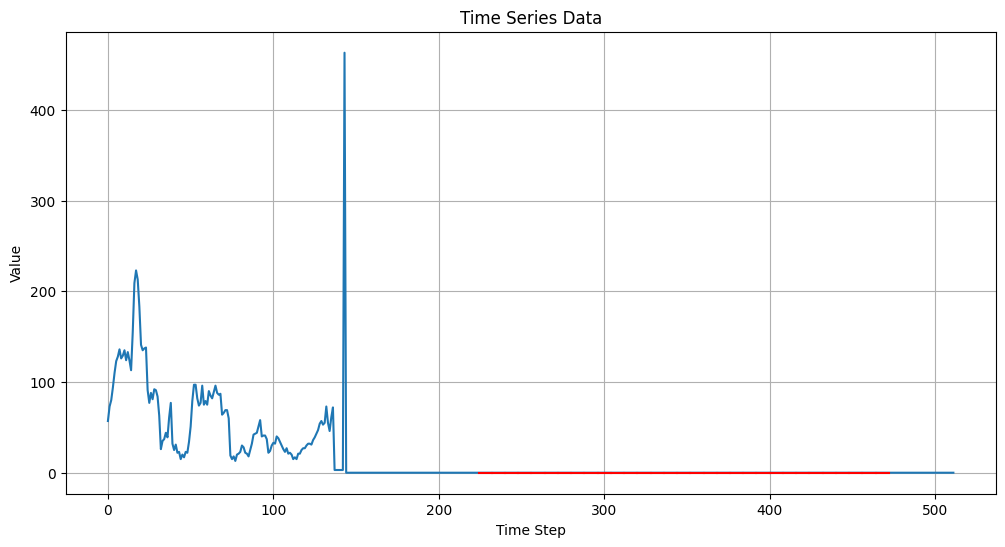

In [49]:
plot_time_series(seq_x, collated_masks_enc[0], p=patch_size)

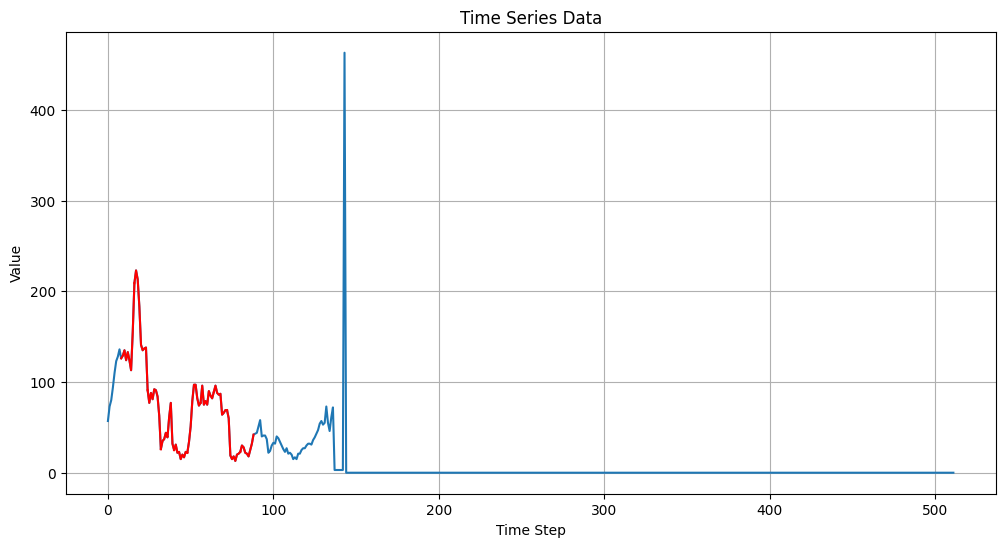

In [50]:
plot_time_series(seq_x, collated_masks_pred[0], p=patch_size)

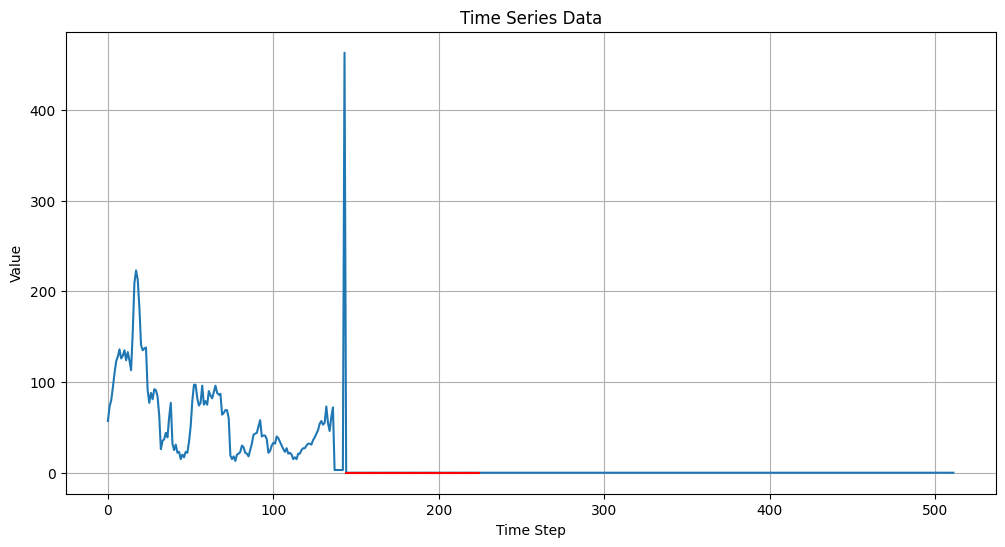

In [51]:
plot_time_series(seq_x, collated_masks_pred[1], p=patch_size)

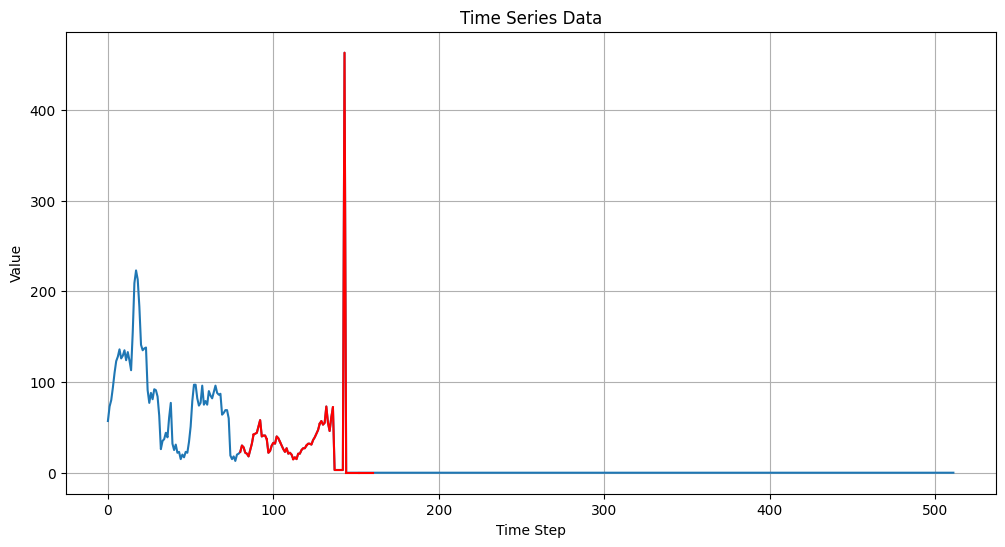

In [52]:
plot_time_series(seq_x, collated_masks_pred[2], p=patch_size)

In [53]:
def forward_context():
    with torch.no_grad():
        encoder_embd = encoder_model(seq_x, collated_masks_enc)
        predictor_embd = predictor_model(encoder_embd[0], collated_masks_enc, collated_masks_pred)
        return encoder_embd[0], predictor_embd[0]

def forward_target():
    with torch.no_grad():
        h = target_encoder_model(seq_x)
        a = F.layer_norm(h[0], (h[0].size(-1),))  # normalize over feature-dim
        B = len(a[0])
        # -- create targets (masked regions of h)
        a = apply_masks(a, collated_masks_pred)
        return h[0], a
def loss_fn(z, h):
    loss = F.mse_loss(z, h)
    return loss

encoder_embd, predictor_embd = forward_context()
full_target_embd, target_embd = forward_target()
loss = loss_fn(predictor_embd, target_embd)

In [54]:
print(loss)

tensor(0.0716)


In [55]:
encoder_embd.shape

torch.Size([1, 1, 31, 64])

In [56]:
predictor_embd.shape

torch.Size([3, 1, 10, 64])

In [57]:
target_embd.shape

torch.Size([3, 1, 10, 64])

In [58]:
print(predictor_embd.norm(dim=3))
print(predictor_embd)

tensor([[[7.3312, 7.4618, 7.5144, 7.5587, 7.6703, 7.7303, 7.6870, 7.6466,
          7.6589, 7.6857]],

        [[7.7330, 7.7860, 7.7910, 7.8270, 7.8758, 7.8804, 7.8433, 7.7870,
          7.8447, 7.8550]],

        [[7.6014, 7.5771, 7.6232, 7.6811, 7.6783, 7.6781, 7.6743, 7.6695,
          7.7018, 7.7602]]])
tensor([[[[-0.0862,  0.5644,  1.1702,  ...,  0.5414, -1.3032, -0.6897],
          [-0.1895, -0.1422,  1.2190,  ...,  0.6983, -1.2929, -0.8582],
          [-0.8146, -0.5299,  1.0960,  ...,  0.8437, -1.2590, -0.9061],
          ...,
          [-0.5882,  0.2013, -0.0495,  ...,  0.4221, -1.3333, -1.0842],
          [-1.0004, -0.2439,  0.3998,  ...,  0.5456, -1.2944, -1.0482],
          [-1.6790, -0.1597,  0.7350,  ...,  0.6681, -1.2983, -0.9473]]],


        [[[-1.1180,  0.6380, -0.0188,  ...,  1.4945, -1.2239, -0.2981],
          [-0.2952,  0.9327, -0.1340,  ...,  1.4106, -1.2617, -0.2319],
          [ 0.3740,  0.4746, -0.4174,  ...,  1.4617, -1.2917, -0.2268],
          ...,
         

In [59]:
print(target_embd.norm(dim=3))
print(target_embd)

tensor([[[8.0000, 8.0000, 8.0000, 8.0000, 8.0000, 8.0000, 8.0000, 8.0000,
          8.0000, 8.0000]],

        [[8.0000, 8.0000, 8.0000, 8.0000, 8.0000, 8.0000, 8.0000, 8.0000,
          8.0000, 8.0000]],

        [[8.0000, 8.0000, 8.0000, 8.0000, 8.0000, 8.0000, 8.0000, 8.0000,
          8.0000, 8.0000]]])
tensor([[[[-0.1428,  0.9317,  1.0368,  ...,  0.5633, -1.1379, -0.4014],
          [-0.6836,  0.4678,  1.3392,  ...,  0.5038, -1.0741, -0.6586],
          [-0.9035, -0.6181,  1.2131,  ...,  0.8506, -1.2945, -0.9824],
          ...,
          [-0.8160,  0.3561,  0.0539,  ...,  0.4589, -1.2747, -1.0960],
          [-1.4904, -0.3628,  0.9410,  ...,  0.3426, -1.3683, -1.4101],
          [-1.7597, -0.4055,  0.9488,  ...,  0.5298, -1.2557, -1.4025]]],


        [[[-0.9730,  0.6671,  0.0112,  ...,  1.5744, -1.2436, -0.2610],
          [-0.0905,  0.9931, -0.1521,  ...,  1.4912, -1.3097, -0.0929],
          [ 0.5837,  0.4453, -0.4679,  ...,  1.5536, -1.2963, -0.1085],
          ...,
         

In [60]:
print(encoder_embd.norm(dim=3))
print(encoder_embd)

tensor([[[7.9572, 7.9553, 7.9533, 7.9456, 7.9393, 7.9421, 7.9433, 7.9362,
          7.9277, 7.9259, 7.9246, 7.9229, 7.9274, 7.9313, 7.9269, 7.9233,
          7.9249, 7.9233, 7.9174, 7.9136, 7.9143, 7.9148, 7.9146, 7.9234,
          7.9448, 7.9515, 7.9499, 7.9436, 7.9346, 7.9321, 7.9426]]])
tensor([[[[-0.0187, -0.7624,  0.5588,  ...,  1.4072, -1.1986, -0.6697],
          [-0.8545, -0.6122,  0.4054,  ...,  1.4721, -1.1849, -0.4083],
          [-1.2977,  0.0556, -0.0699,  ...,  1.5617, -1.2690,  0.2200],
          ...,
          [-1.8579,  0.2407, -1.5313,  ...,  1.1194, -0.6914,  2.0226],
          [-0.8703,  0.2203, -1.7268,  ...,  1.0687, -0.8266,  1.8879],
          [-0.3430, -0.5194, -1.1777,  ...,  1.0754, -1.0910,  1.3196]]]])


In [61]:
print(full_target_embd.norm(dim=3))
print(full_target_embd)

tensor([[[7.9220, 7.9098, 7.8991, 7.9037, 7.9248, 7.9372, 7.9196, 7.9291,
          7.9430, 7.9542, 7.9571, 7.9492, 7.9491, 7.9526, 7.9568, 7.9555,
          7.9512, 7.9372, 7.9423, 7.9393, 7.9365, 7.9350, 7.9368, 7.9392,
          7.9374, 7.9354, 7.9409, 7.9485, 7.9496, 7.9471, 7.9407, 7.9333,
          7.9309, 7.9363, 7.9422, 7.9382, 7.9312, 7.9281, 7.9261, 7.9236,
          7.9243, 7.9272, 7.9260, 7.9250, 7.9259, 7.9241, 7.9192, 7.9170,
          7.9195, 7.9213, 7.9212, 7.9250, 7.9377, 7.9442, 7.9394, 7.9320,
          7.9301, 7.9310, 7.9386, 7.9543, 7.9602, 7.9565, 7.9506, 7.9457]]])
tensor([[[[-0.2229,  1.0638,  0.8180,  ...,  0.4654, -1.1285, -0.5157],
          [-0.1416,  0.9208,  1.0247,  ...,  0.5565, -1.1255, -0.3973],
          [-0.6748,  0.4620,  1.3225,  ...,  0.4976, -1.0604, -0.6502],
          ...,
          [-2.2485, -0.4966,  0.4086,  ...,  1.6447, -1.2449,  1.1069],
          [-1.9660,  0.3764, -0.0583,  ...,  1.3958, -1.1801,  1.2856],
          [-1.0667,  0.6752, -